# Vehicle Insurance Cross Sell Prediction

### Setup

In [546]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from patsy import dmatrices
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [475]:
#path for data
path = '.'
data_path = path + '/data/'

In [476]:
#load data
data = pd.read_csv(data_path + 'train.csv') #technically full 
#test_data = pd.read_csv(data_path + 'test.csv') - for contest submission purposes (just create val based on full)

In [477]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [478]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [479]:
data.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [480]:
"""
Project:
Build model to predict whether customers from past year will be interested in vehicle insurance

Notes:
Target variable: response - look at distribution
Data seems all cleaned
encode categorical variables (driving license, gender, vehicle_age, vehicle_damage, previously insured)
scale numerical variables 
Understand columns:
    -previously insured: customer already has insurance 1, no insurance 0 
    -annual premium: amount customer needs to pay for premium in the year
    -policy sales channel: Anon code to outreach to the customer
    -vintage: days customer has been associated with company
    -region code: unique code for region of customer




Eval metrics: ROC_AUC score
"""

'\nProject:\nBuild model to predict whether customers from past year will be interested in vehicle insurance\n\nNotes:\nTarget variable: response - look at distribution\nData seems all cleaned\nencode categorical variables (driving license, gender, vehicle_age, vehicle_damage, previously insured)\nscale numerical variables \nUnderstand columns:\n    -previously insured: customer already has insurance 1, no insurance 0 \n    -annual premium: amount customer needs to pay for premium in the year\n    -policy sales channel: Anon code to outreach to the customer\n    -vintage: days customer has been associated with company\n    -region code: unique code for region of customer\n\n\n\n\nEval metrics: ROC_AUC score\n'

### EDA on Variables

Text(0.5, 1.0, 'Response Count Plot')

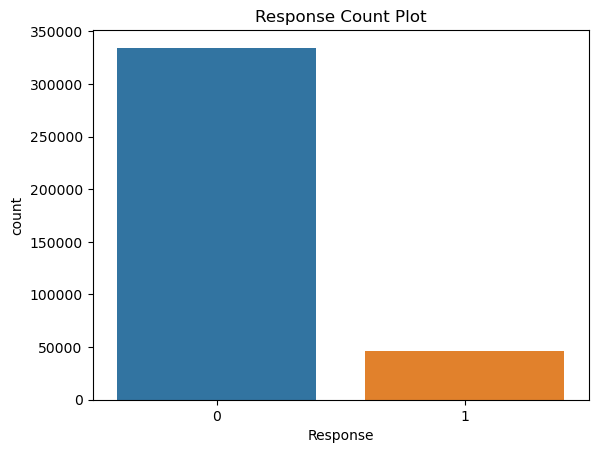

In [481]:
#distribution of response variable - binary: zero inflated model (poisson, negative binomial)
ax = sns.countplot(data, x= 'Response')
ax.set_title('Response Count Plot')

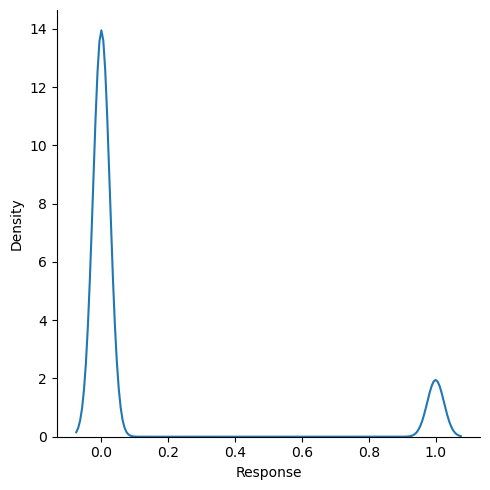

In [482]:
sns.displot(data['Response'], kind = 'kde')
plt.show()

In [483]:
target = ['Response']
numerical_features = ['Age','Annual_Premium','Vintage']
categorical_features = ['Gender','Driving_License','Region_Code','Previously_Insured',
                        'Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel']

Number of Unique Region Codes: 53


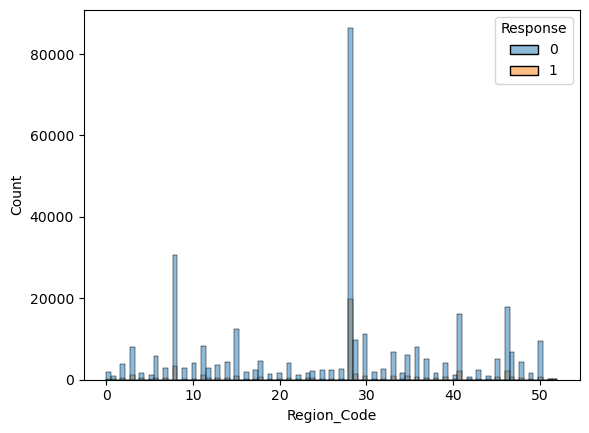

Number of Unique Policy Sales Channels: 155


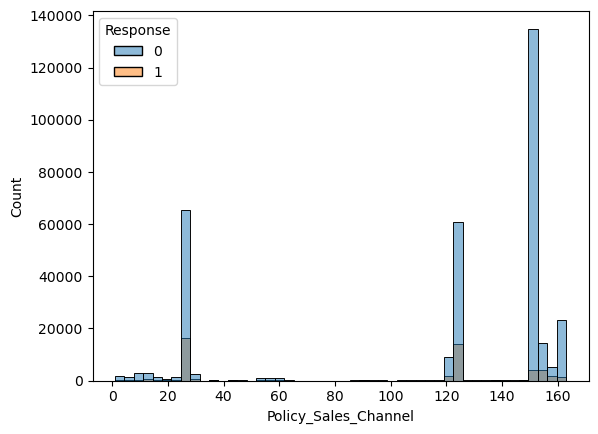

In [484]:
print(f"Number of Unique Region Codes: {len(data['Region_Code'].unique())}")
sns.histplot(data, x = 'Region_Code', hue = 'Response')
plt.show()
print(f"Number of Unique Policy Sales Channels: {len(data['Policy_Sales_Channel'].unique())}")
sns.histplot(data, x = 'Policy_Sales_Channel', hue = 'Response')
plt.show()

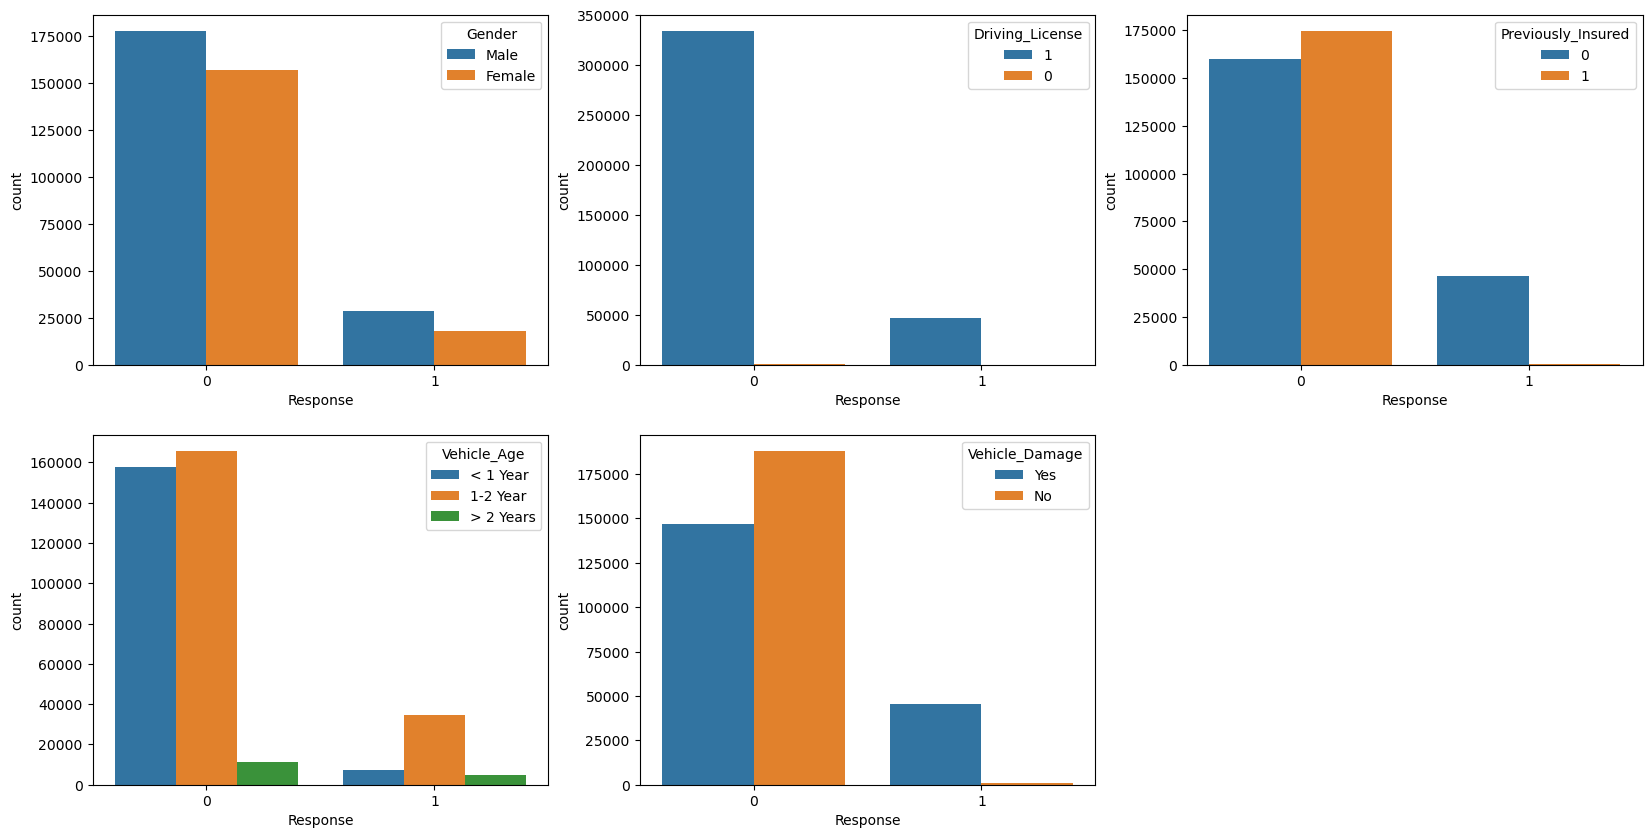

In [485]:
#changing type for graphing
data['Previously_Insured'] = data['Previously_Insured'].astype(str)
data['Driving_License'] = data['Driving_License'].astype(str)
#plotting categorical features to understand relationships
countplot_features = ['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage']
plt.figure(figsize = (20,10))
for i in range(len(countplot_features)):
    plt.subplot(2,3,i+1)
    if countplot_features[i] == 'Vehicle_Age':
        sns.countplot(data, x = 'Response', hue = countplot_features[i], hue_order = ['< 1 Year','1-2 Year','> 2 Years'])
    else:
        sns.countplot(data, x = 'Response', hue = countplot_features[i])
plt.show()

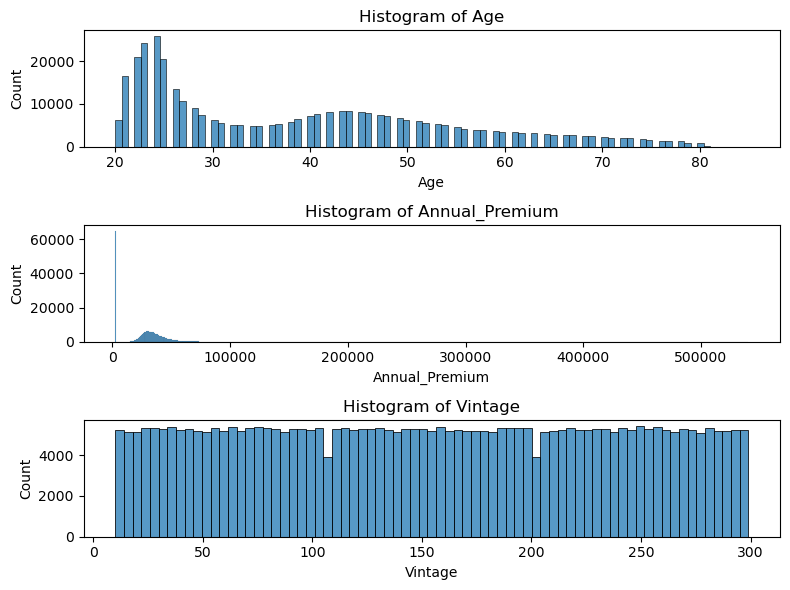

In [486]:
#looking at distributions of numerical features
plt.figure(figsize = (8,6), tight_layout = 'True')
for i in range(len(numerical_features)):
    plt.subplot(3,1,i+1)
    sns.histplot(data[numerical_features[i]])
    plt.title(f'Histogram of {numerical_features[i]}')
plt.show()

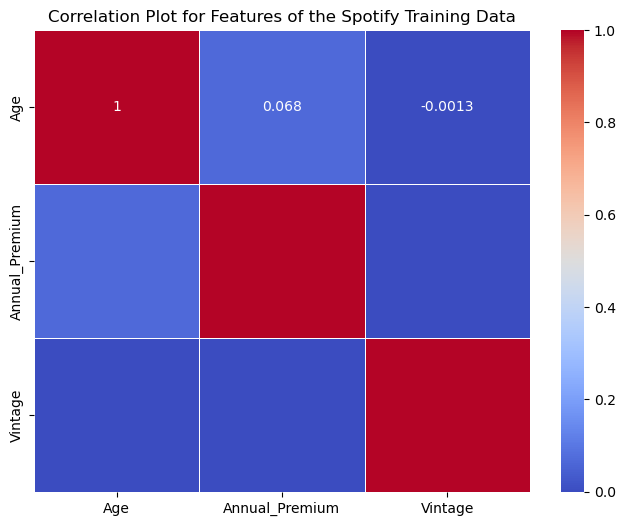

In [487]:
#checking correlation on numerical features - for checking multicolinearity
plt.figure(figsize=(8,6))
corr = data[numerical_features].corr()
sns.heatmap(corr, annot = True, cmap= 'coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Plot for Features of the Spotify Training Data')

plt.show()

#### Notes
* Unsure on how Region and Policy Sales Channel will affect model - leave those out for now since high dim categorical
* Target Variable (Response) - Binary (Heavy on 0s): Can use a zero inflated model (poisson, negative binomial) 

### Create a Validation Set

In [488]:
features = ['Age','Annual_Premium','Vintage', 'Gender','Driving_License','Previously_Insured',
                        'Vehicle_Age','Vehicle_Damage'] #Region_Code, Policy_Sales_Channel
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size = 0.2, random_state = 42)
print('X_train size: ',X_train.shape)
print('X_test size: ',X_test.shape)

X_train size:  (304887, 8)
X_test size:  (76222, 8)


In [489]:
X_train.head()

,Age,Annual_Premium,Vintage,Gender,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage
332803,39,52906.0,227,Female,1,0,1-2 Year,Yes
116248,38,23038.0,29,Male,1,0,1-2 Year,Yes
255005,22,45318.0,166,Male,1,1,< 1 Year,No
317474,23,29132.0,277,Female,1,1,< 1 Year,No
344212,56,2630.0,155,Male,1,0,> 2 Years,Yes


### Feature Scaling

In [490]:
#udpated features
numerical_features = ['Age','Annual_Premium','Vintage']
categorical_features = ['Driving_License','Previously_Insured',
                        'Vehicle_Age','Vehicle_Damage'] #'Region_Code', 'Policy_Sales_Channel', Gender

scaler = StandardScaler()
encoder = OneHotEncoder()

In [491]:
X_train_numericals = scaler.fit_transform(X_train[numerical_features])
X_train_categories = encoder.fit_transform(X_train[categorical_features]).toarray()
X_train_scaled = np.hstack((X_train_numericals,X_train_categories))

/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

In [492]:
y_train = y_train['Response'].values
y_test = y_test['Response'].values

In [493]:
X_train_scaled[0]

array([0.01060114, 1.29441692, 0.86950541, 0.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 1.        ])

In [494]:
encoder.categories_

[array(['0', '1'], dtype=object),
 array(['0', '1'], dtype=object),
 array(['1-2 Year', '< 1 Year', '> 2 Years'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

In [495]:
X_test_numericals = scaler.transform(X_test[numerical_features])
X_test_categories = encoder.transform(X_test[categorical_features]).toarray()
X_test_scaled = np.hstack((X_test_numericals, X_test_categories))

/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


### Modeling

#### Majority Baseline Modeling

In [496]:
unique, counts = np.unique(y_train, return_counts = True)
print(unique, counts)

[0 1] [267700  37187]


In [497]:
baseline_train = np.zeros_like(y_train)
baseline_test = np.zeros_like(y_test)

In [498]:
print('Baseline Train Accuracy Score: ', accuracy_score(y_train, baseline_train))
print('Baseline Test Accuracy Score: ', accuracy_score(y_test, baseline_test))

Baseline Train Accuracy Score:  0.8780302210327104
Baseline Test Accuracy Score:  0.8750623179659416


#### Logistic Regression - Unbalanced

In [499]:
lr_clf = LogisticRegression(penalty = 'l2') 

In [500]:
lr_clf.fit(X_train_scaled, y_train)

LogisticRegression()

In [501]:
lr_clf.score(X_train_scaled, y_train)

0.8780236612253064

In [502]:
y_train_pred = lr_clf.predict(X_train_scaled)

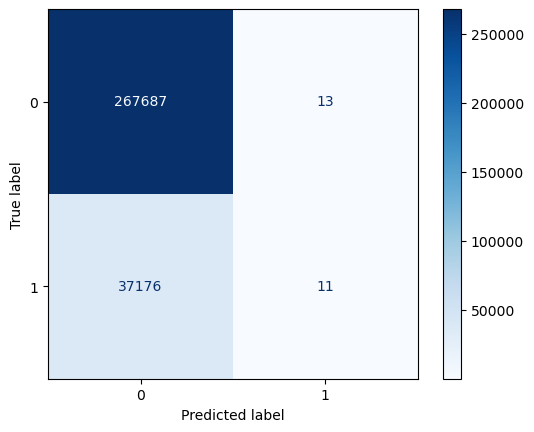

In [503]:
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf.classes_)
disp.plot(cmap='Blues')
plt.show()

#### Logistic Regression - Balanced

In [504]:
#NEEDS BALANCING
print(len(y_train[y_train == 1]))
train_0_indexes = np.where(y_train == 0)[0]

37187


In [505]:
train_0_indexes = train_0_indexes[:len(y_train[y_train == 1])]

In [506]:
balanced_indexes = np.hstack((train_0_indexes, np.where(y_train == 1)[0]))

In [507]:
X_train_balanced = X_train_scaled[balanced_indexes]
y_train_balanced = y_train[balanced_indexes]
print(X_train_balanced.shape)
print(y_train_balanced.shape)

(74374, 12)
(74374,)


In [508]:
lr_clf = LogisticRegression()

In [509]:
lr_clf.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [510]:
lr_clf.score(X_train_balanced, y_train_balanced)

0.7838760857288838

In [511]:
lr_clf.score(X_test_scaled, y_test)

0.6416126577628506

#### Random Forest - Balanced

In [512]:
gb_clf = GradientBoostingClassifier()

In [513]:
param_grid = {'learning_rate':[0.1, 0.05, 0.025], 'n_estimators':[100,150,200], 'max_depth':[3,4,5]}
gb_clf = GridSearchCV(gb_clf, param_grid)
#best params: learning_rate = 0.05, max_depth = 5, n_estimators = 100

In [514]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 5, n_estimators = 100)

In [515]:
gb_clf.fit(X_train_balanced, y_train_balanced)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5)

In [516]:
gb_clf.score(X_train_balanced, y_train_balanced)

0.7954527119692366

In [517]:
gb_clf.score(X_test_scaled, y_test) #0.7

0.6866259085303456

In [518]:
y_train_pred = gb_clf.predict(X_train_scaled)

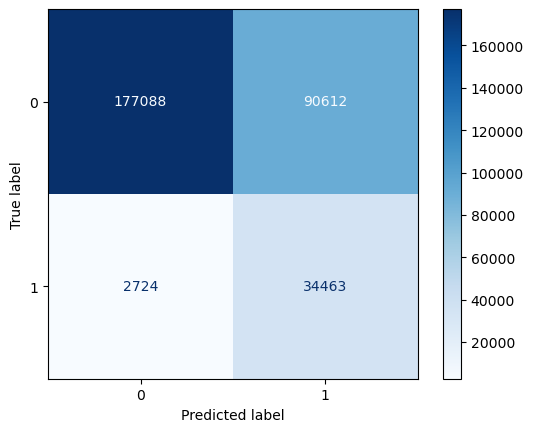

In [465]:
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf.classes_)
disp.plot(cmap='Blues')
plt.show()

#### GLM - Poisson

In [519]:
features = ['Age','Annual_Premium','Vintage', 'Gender','Driving_License','Previously_Insured',
                        'Vehicle_Age','Vehicle_Damage'] #Region_Code, Policy_Sales_Channel
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size = 0.2, random_state = 42)
print('X_train size: ',X_train.shape)
print('X_test size: ',X_test.shape)

X_train size:  (304887, 8)
X_test size:  (76222, 8)


In [520]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_features] = scaler.transform(X_train_scaled[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_scaled[numerical_features])

/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

In [521]:
train_data = pd.concat((X_train_scaled, y_train),axis = 1)
test_data = pd.concat((X_test_scaled, y_test), axis = 1)
train_data.head()

,Age,Annual_Premium,Vintage,Gender,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Response
332803,0.010601,1.294417,0.869505,Female,1,0,1-2 Year,Yes,1
116248,-0.053875,-0.436638,-1.497719,Male,1,0,1-2 Year,Yes,0
255005,-1.085502,0.854640,0.140209,Male,1,1,< 1 Year,No,0
317474,-1.021025,-0.083449,1.467289,Female,1,1,< 1 Year,No,0
344212,1.106704,-1.619422,0.008696,Male,1,0,> 2 Years,Yes,0


In [388]:
#use patsy
#'Response ~ Age + Annual_Premium + Vintage + Gender + Driving_License + Previously_Insured + Vehicle_Age + Vehicle_Damage' .88 train
reg_formula = 'Response ~ Age + Annual_Premium + Vintage + Gender + Driving_License + Previously_Insured + Vehicle_Age + Vehicle_Damage'
y_train, X_train_scaled = dmatrices(reg_formula, data = train_data, return_type = 'dataframe')

In [389]:
poisson_model = sm.GLM(y_train, X_train_scaled, family = sm.families.Poisson())

In [390]:
result = poisson_model.fit()
print(result.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:               304887
Model:                            GLM   Df Residuals:                   304877
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -89293.
Date:                Mon, 23 Dec 2024   Deviance:                   1.0421e+05
Time:                        13:24:58   Pearson chi2:                 2.29e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1575
Covariance Type:            nonrobust  

In [391]:
y_train_pred = result.predict(X_train_scaled)

In [392]:
y_train_pred[y_train_pred >= 0.5] = 1
y_train_pred[y_train_pred < 0.5] = 0

In [393]:
unique, counts = np.unique(y_train_pred, return_counts = True)
print(unique, counts)

[0. 1.] [304846     41]


In [394]:
accuracy_score(y_train, y_train_pred)

0.8779941420919882

### Negative Binomial

In [395]:
negbi_model = sm.GLM(y_train, X_train_scaled, family = sm.families.NegativeBinomial())

/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [396]:
result = negbi_model.fit()
print(result.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:               304887
Model:                            GLM   Df Residuals:                   304877
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -93797.
Date:                Mon, 23 Dec 2024   Deviance:                       84489.
Time:                        13:24:59   Pearson chi2:                 2.07e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1446
Covariance Type:            nonrobust  

In [397]:
y_train_pred = result.predict(X_train_scaled)

In [398]:
y_train_pred[y_train_pred >= 0.5] = 1
y_train_pred[y_train_pred < 0.5] = 0

In [399]:
unique, counts = np.unique(y_train_pred, return_counts = True)
print(unique, counts)

[0. 1.] [304843     44]


In [400]:
accuracy_score(y_train, y_train_pred)

0.8779908621882861

### Zero Inflated Poisson

In [541]:
reg_formula = 'Response ~ Age + Annual_Premium + Driving_License + Previously_Insured + Vehicle_Age + Vehicle_Damage'
y_train, X_train_scaled = dmatrices(reg_formula, data = train_data, return_type = 'dataframe')
y_test, X_test_scaled = dmatrices(reg_formula, data = test_data, return_type = 'dataframe')

In [530]:
zero_poisson = sm.ZeroInflatedPoisson(y_train, X_train_scaled)
result = zero_poisson.fit()
print(result.summary())

/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/scipy/optimize/_optimize.py:1397: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.294210
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/opt/anaconda3/envs/ds207/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                Response   No. Observations:               304887
Model:             ZeroInflatedPoisson   Df Residuals:                   304879
Method:                            MLE   Df Model:                            7
Date:                 Mon, 23 Dec 2024   Pseudo R-squ.:                  0.2229
Time:                         14:25:16   Log-Likelihood:                -89701.
converged:                       False   LL-Null:                   -1.1543e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
inflate_const               -4.6831      0.136    -34.505      0.000      -4.949      -4.417
Intercept                   -3.0721      0.093    -33.033      0.000      -3.254 

In [531]:
y_train_pred = result.predict(X_train_scaled)

In [532]:
y_train_pred[y_train_pred >= 0.5] = 1
y_train_pred[y_train_pred < 0.5] = 0

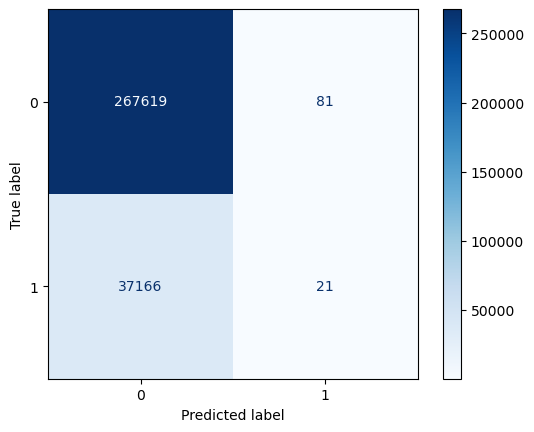

In [533]:
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot(cmap='Blues')
plt.show()

In [534]:
accuracy_score(y_train, y_train_pred)

0.8778334268105888

In [542]:
y_test_pred = result.predict(X_test_scaled)

In [543]:
y_test_pred[y_test_pred >= 0.5] = 1
y_test_pred[y_test_pred < 0.5] = 0

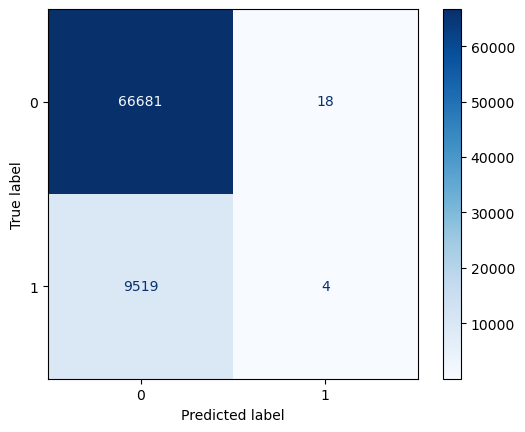

In [544]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot(cmap='Blues')
plt.show()

In [547]:
print('Test Accuracy: ', accuracy_score(y_test, y_test_pred))
print('Test Recall: ', recall_score(y_test, y_test_pred))
print('Test Precision: ', precision_score(y_test, y_test_pred))
print('Test f1: ', f1_score(y_test, y_test_pred))

Test Accuracy:  0.8748786439610611
Test Recall:  0.00042003570303475793
Test Precision:  0.18181818181818182
Test f1:  0.0008381351492928235
